# Implied Volatility Surface Visualizer

This notebook visualizes the implied volatility surface for the VOO ETF.

## Realized Volatility

Realized volatility is the standard deviation of the returns of an asset over a given period of time. It is a measure of the volatility of an asset's returns and is often used as a proxy for the expected volatility of an asset.

## Implied Volatility

Implied volatility is the volatility of an asset's returns that is inferred from the prices of options on the asset. It is a measure of the expected volatility of an asset's returns and is often used as a proxy for the expected volatility of an asset.

Lets start off by visualizing the realized volatility of the S&P 500 index (SPX).

[*********************100%***********************]  1 of 1 completed


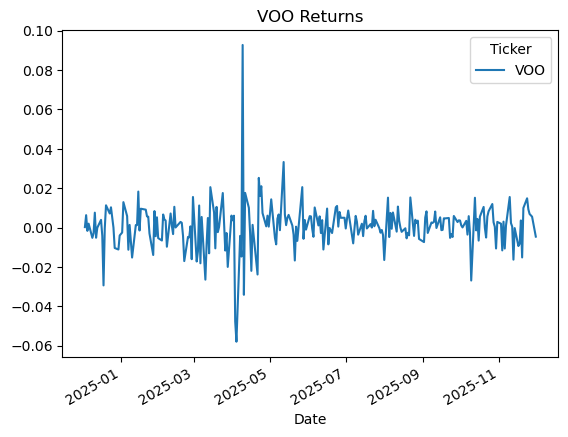

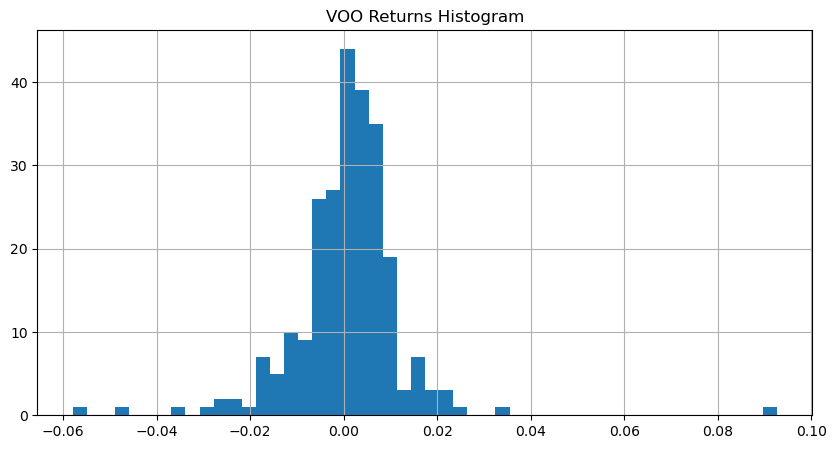

Mean %:  Ticker
VOO    0.06008
dtype: float64
STDEV %:  Ticker
VOO    1.187566
dtype: float64
Skewness:  Ticker
VOO    0.936762
dtype: float64
Kurtosis:  Ticker
VOO    17.219138
dtype: float64


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq



voo = yf.download("VOO", period="1y", auto_adjust=True)["Close"]
voo_returns = voo.pct_change().dropna()


voo_returns.plot()
plt.title("VOO Returns")
plt.show()

histogram = voo_returns.hist(bins=50, figsize=(10, 5))
plt.title("VOO Returns Histogram")
plt.show()

print("Mean %: ", voo_returns.mean() * 100)
print("STDEV %: ", voo_returns.std() * 100)
print("Skewness: ", voo_returns.skew())
print("Kurtosis: ", voo_returns.kurt())


Lets visualize the Implied Volatility using options.

In the 3D surface, implied volatility takes in 2 inputs: time to expiration and strike price, hence the 3d surface.

To find the implied volatility, we decided to derive implied volatility from option contracts using the black-scholes-model and Brent's Method.

## What we need:
### $ d_1 $
$ d_1 $ represents the z-score of the delta. It measures the option's sensitivity to price changes, acting as the probability of exercise weighted by asset value.

#### $$ d_1 = \frac{\ln(\frac{S}{K}) + (r + \frac{\sigma^2}{2})T}{\sigma\sqrt{T}} $$

- $ S = $ Spot Price
- $ K = $ Strike Price
- $ T = $ Time to Expiration
- $ r = $ Risk Free Rate
- $ \sigma = $ Volatility

#### Breakdown of equation:
- $ \ln(\frac{S}{K}) $ represents the current moneyness of the options contract
- $ {(r + \frac{\sigma^2}{2})T} $ represents the drift the moneyness can exhibit given a certain volatility, time to expiration, interest rate, and dividends
- $ {\sigma\sqrt{T}} $ simply normalizes the equation to fit a normal distribution of mean 0 and standard deviation of 1

### $ d_2 $
$ d_2 $ represents the z-score of the probability of the options contract expiring in the money.

#### $$ d_2 = d_1 - \sigma\sqrt{T} $$
simply subtracting $ d_1 $ by the cumulative total volatility over the life of the contract can give us the probability of the contract expiring in the money.

Using both the z-scores, we can find the price of the price of a call/put option

#### $$ C = S * N(d_1) - K * e^{-rT} * N(d_2) $$
#### $$ P = K * e^{-rT} * N(-d_2) - S * N(-d_1) $$

Here is the formula defined in code

In [ ]:
def black_scholes_price(sigma, S, K, T, r, q, option_type='call'):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)
    return price

Now, we need a way to correctly guess the Implied Volatility of the contract with a low margin of error. We can do this by plugging in different values of implied volatility into the formula to the point where the formula spits out an option price that is the same as the actual option price.

We can do this by using Brent's Method, a root finding algorithm.

In [ ]:
def calculate_iv(market_price, S, K, T, r, q, option_type='call'):
    def objective(sigma): # solving for sigma
        return black_scholes_price(sigma, S, K, T, r, q, option_type) - market_price

    try:
        return brentq(objective, 0.001, 5.0) # We assume IV to be somewhere between 0.1% and 500%
    except:
        return np.nan

Now we have our functions working, lets look at the relationship between implied volatility and strike prices at a given expiration date for VOO.

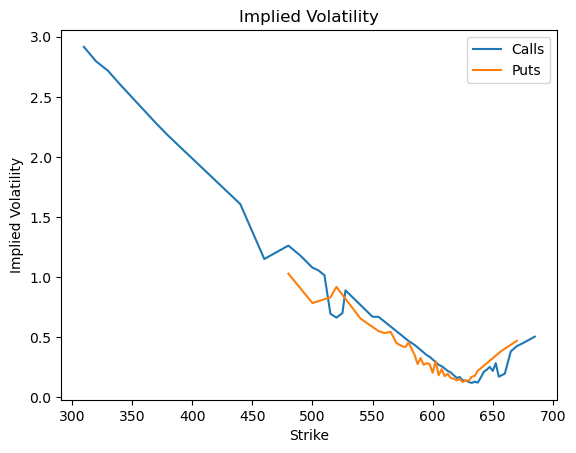

In [ ]:
def plot_implied_volatility_strikes():
    chain = voo.option_chain(exps[0]) # nearest expiration
    plt.plot(chain.calls['strike'], chain.calls['impliedVolatility'])
    plt.plot(chain.puts['strike'], chain.puts['impliedVolatility'])
    plt.title("Implied Volatility")
    plt.legend(['Calls', 'Puts'])
    plt.xlabel("Strike")
    plt.ylabel("Implied Volatility")
    plt.show()

ticker = 'VOO'
voo = yf.Ticker(ticker)
current_price = voo.history(period="1d")['Close'].iloc[-1]
exps = voo.options
risk_free_rate = 0.046 # Assumes fixed risk free rate
dividend_yield = 0.013 # Assumes fixed dividend yield

plot_implied_volatility_strikes()

Looks like the model is working, a smile/smirk is the usual shape of Strike/IV relationship. This is because a higher IV is required to reach deep in the money or out the money strike prices.

Now, lets compare different expirations with IV at a certain strike.

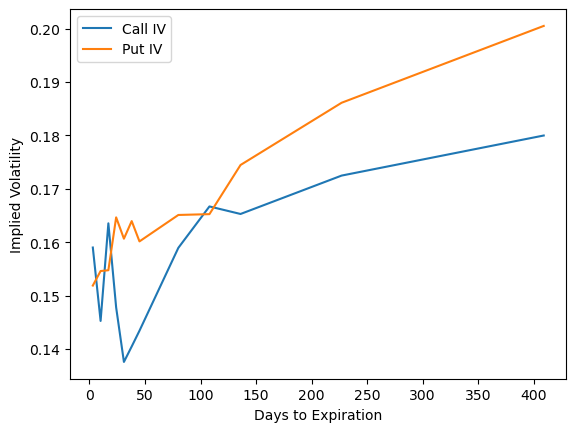

In [ ]:
ivs = []

for exp in exps[:12]:
    chain = voo.option_chain(exp)
    days_to_exp = (pd.to_datetime(exp) - pd.to_datetime('today')).days
    t_normalized = days_to_exp / 365

    calls = chain.calls
    puts = chain.puts

    atm_calls = calls.iloc[(calls['strike'] - current_price).abs().argsort()[:1]].iloc[0]
    atm_puts = puts.iloc[(puts['strike'] - current_price).abs().argsort()[:1]].iloc[0]

    call_price = (atm_calls['bid'] + atm_calls['ask']) / 2
    put_price = (atm_puts['bid'] + atm_puts['ask']) / 2

    call_iv = calculate_iv(call_price, current_price, atm_calls['strike'], t_normalized, risk_free_rate, dividend_yield, option_type='call')
    put_iv = calculate_iv(put_price, current_price, atm_puts['strike'], t_normalized, risk_free_rate, dividend_yield, option_type='put')

    ivs.append((days_to_exp, call_iv, put_iv))

ivs = pd.DataFrame(ivs, columns=['days_to_exp', 'call_iv', 'put_iv'])

plt.plot(ivs['days_to_exp'], ivs['call_iv'], label='Call IV')
plt.plot(ivs['days_to_exp'], ivs['put_iv'], label='Put IV')
plt.xlabel('Days to Expiration')
plt.ylabel('Implied Volatility')
plt.legend()
plt.show()

This looks generally correct too. Implied Volatility increases as time to expiration increases, because there is more time for drastic changes to occur.